In [1]:
import face_recognition
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import os
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input,Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import imutils
import seaborn as sns
import dlib

import numpy as np
import cv2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import pandas as pd
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import imutils
import dlib

In [2]:
# Converting all the images into an array
def load_images_from_folder(folder, eyes = 0):
    count = 0
    error_count = 0
    images = []
    for filename in os.listdir(folder):
        try:
            img = cv2.imread(os.path.join(folder,filename))
            img = cv2.resize(img, (80,80)) ## Resizing the images
            ## for eyes if it is 0: open, 1: close
            images.append([img, eyes])
        # need a try or except or else it will give an error when resizing the images
        except:
          error_count += 1
          print('ErrorCount = ' + str(error_count))
          continue
        count += 1
        if count % 500 == 0:
          print('Succesful Image Import Count = ' + str(count))

    return images

# Pulling open eye images from directory and passing through image loading function
folder="D:\\490jupy\\CNN Drowsiness Detection Using a Convolutional Neural Network\\data\\train\\CNN_open"
open_eye = load_images_from_folder(folder, 0)

# Pulling closed eye images from directory and passing through image loading function
folder="D:\\490jupy\\CNN Drowsiness Detection Using a Convolutional Neural Network\\data\\train\\CNN_closed"
close_eye = load_images_from_folder(folder, 1)

Succesful Image Import Count = 500
Succesful Image Import Count = 1000
Succesful Image Import Count = 1500
Succesful Image Import Count = 2000
Succesful Image Import Count = 2500
Succesful Image Import Count = 3000
Succesful Image Import Count = 3500
Succesful Image Import Count = 4000
Succesful Image Import Count = 4500
Succesful Image Import Count = 5000
Succesful Image Import Count = 5500
Succesful Image Import Count = 6000
Succesful Image Import Count = 6500
Succesful Image Import Count = 7000
Succesful Image Import Count = 7500
Succesful Image Import Count = 8000
Succesful Image Import Count = 8500
Succesful Image Import Count = 9000
Succesful Image Import Count = 9500
Succesful Image Import Count = 10000
Succesful Image Import Count = 10500
Succesful Image Import Count = 11000
Succesful Image Import Count = 11500
Succesful Image Import Count = 12000
Succesful Image Import Count = 12500
Succesful Image Import Count = 13000
Succesful Image Import Count = 13500
Succesful Image Impor

In [3]:
print(len(open_eye))
print(len(close_eye))
eye = close_eye + open_eye

26350
1974


In [4]:
X = []
Y = []

for features, label in eye:
    X.append(features)
    Y.append(label)
X = list(X)
Y = list(Y)
print(len(X))
print(len(Y))

28324
28324


In [5]:
for i in range(len(X)):
    img = X[i]
    img = cv2.resize(img, (80, 80))
    X[i] = img
    
print(len(X))
print(X[0].shape)

28324
(80, 80, 3)


In [6]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
print(Y.shape)
print(Y[27000])
print(set(Y))

(28324,)
0
{0, 1}


In [7]:
X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

(28324, 80, 80, 3)
(28324,)


In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [9]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(22659, 80, 80, 3)
(22659,)
(5665, 80, 80, 3)
(5665,)
(22659, 80, 80, 3)
(22659, 2)
(5665, 80, 80, 3)
(5665, 2)


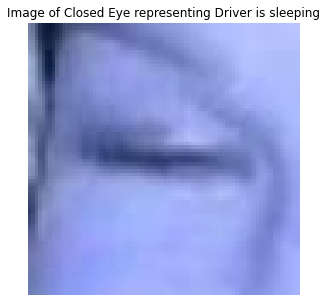

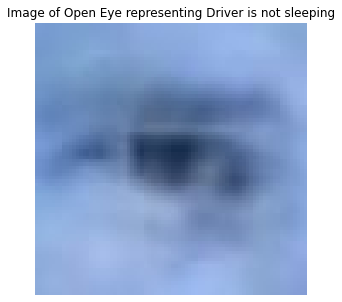

In [10]:
figure1 = plt.figure(figsize=(5, 5))
idx_closed = np.where(Y==1)
img_closed = X[idx_closed[0][0]]
plt.imshow(img_closed)
plt.title('Image of Closed Eye representing Driver is sleeping')
plt.axis('off')
plt.show()

figure2 = plt.figure(figsize=(5, 5))
idx_open = np.where(Y==0)
img_open = X[idx_open[0][0]]
plt.imshow(img_open)
plt.title('Image of Open Eye representing Driver is not sleeping')
plt.axis('off')
plt.show()

In [11]:
def driver_drowsiness_detection_model(input_shape=(80, 80, 3)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(80, (3, 3), padding='same', strides=(1, 1), name='conv1', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Conv2D(80, (3, 3), padding='same', strides=(1, 1), name='conv2', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), padding='same', strides=(1, 1), name='conv3', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(128, (3, 3), padding='same', strides=(1, 1), name='conv4', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), padding='same', strides=(1, 1), name='conv5', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same', strides=(1, 1), name='conv6', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv7', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))
    
    optimizer = Adam(0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
model= driver_drowsiness_detection_model(input_shape=(80, 80, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 80, 80, 80)        2240      
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 80, 80)        320       
_________________________________________________________________
conv2 (Conv2D)               (None, 80, 80, 80)        57680     
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 80, 80)        320       
_________________________________________________________________
dropout (Dropout)            (None, 80, 80, 80)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 80)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 40, 40, 128)       9

In [13]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.2, horizontal_flip=True)
hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=100, validation_data=(X_test, Y_test))

Epoch 1/100
178/178 [==============================] - 339s 2s/step - loss: 0.6994 - accuracy: 0.8337 - val_loss: 0.3383 - val_accuracy: 0.8824
Epoch 2/100
 22/178 [==>...........................] - ETA: 3:44 - loss: 0.2860 - accuracy: 0.9207

KeyboardInterrupt: 

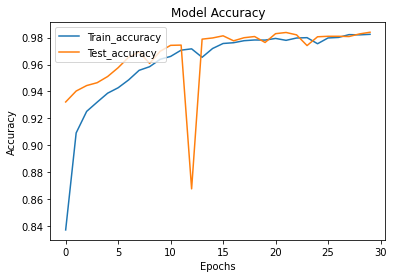

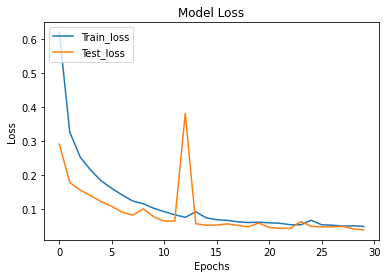

In [14]:
#figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train_accuracy')
plt.plot(hist.history['val_accuracy'], label='Test_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

#figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train_loss')
plt.plot(hist.history['val_loss'], label='Test_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

In [15]:
pred = model.evaluate(X_test, Y_test)
print(f'Test Set Accuracy: {pred[1]}')
print(f'Test Set Loss: {pred[0]}')

178/178 [==============================] - 3s 14ms/step - loss: 0.0402 - accuracy: 0.9838
Test Set Accuracy: 0.9837599396705627
Test Set Loss: 0.04022958502173424


In [16]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_pred = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_pred, ypred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5254
           1       0.89      0.88      0.88       411

    accuracy                           0.98      5665
   macro avg       0.94      0.93      0.94      5665
weighted avg       0.98      0.98      0.98      5665



<AxesSubplot:>

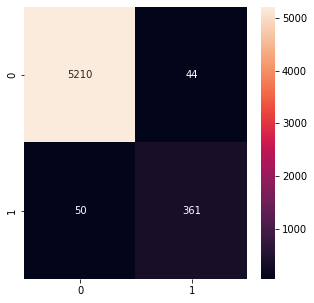

In [17]:
matrix = confusion_matrix(Y_test_pred, ypred)
df_cm = pd.DataFrame(matrix, index=[0, 1], columns=[0, 1])
figure = plt.figure(figsize=(5, 5))
sns.heatmap(df_cm, annot=True, fmt='d')

In [18]:
model.save('Driver_Drowsiness_Detection.h5')


In [2]:
model = keras.models.load_model("Driver_Drowsiness_Detection.h5")

In [3]:
labels = ['Open', 'Closed']
img_closed1 = cv2.imread('D:\\490jupy\\CNN Drowsiness Detection Using a Convolutional Neural Network\\data\\train\\CNN_closed\\eye_crop_closed100.jpg')
img_closed2 = cv2.imread('D:\\490jupy\\CNN Drowsiness Detection Using a Convolutional Neural Network\\data\\train\\CNN_closed\\eye_crop_closed1000.jpg')
img_open1 = cv2.imread('D:\\490jupy\\CNN Drowsiness Detection Using a Convolutional Neural Network\\data\\train\\CNN_open\\eye_crop_open100.jpg')
img_open2 = cv2.imread('D:\\490jupy\\CNN Drowsiness Detection Using a Convolutional Neural Network\\data\\train\\CNN_open\\eye_crop_open1000.jpg')

img_closed1 = cv2.resize(img_closed1, (80, 80))
img_closed2 = cv2.resize(img_closed2, (80, 80))
img_open1 = cv2.resize(img_open1, (80, 80))
img_open2 = cv2.resize(img_open2, (80, 80))

img_closed1 = np.array(img_closed1)
img_closed2 = np.array(img_closed2)
img_open1 = np.array(img_open1)
img_open2 = np.array(img_open2)

img_closed1 = np.expand_dims(img_closed1, axis=0)
img_closed2 = np.expand_dims(img_closed2, axis=0)
img_open1 = np.expand_dims(img_open1, axis=0)
img_open2 = np.expand_dims(img_open2, axis=0)

In [4]:
ypred_closed1 = model.predict(img_closed1)
ypred_closed2 = model.predict(img_closed2)
ypred_open1 = model.predict(img_open1)
ypred_open2 = model.predict(img_open2)

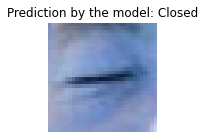

In [5]:
figure = plt.figure(figsize=(2, 2))
img_closed1 = np.squeeze(img_closed1, axis=0)
plt.imshow(img_closed1)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_closed1[0], axis=0)]}')
plt.show()

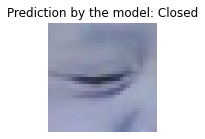

In [6]:
figure = plt.figure(figsize=(2, 2))
img_closed2 = np.squeeze(img_closed2, axis=0)
plt.imshow(img_closed2)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_closed2[0], axis=0)]}')
plt.show()

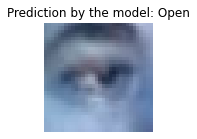

In [7]:
figure = plt.figure(figsize=(2, 2))
img_open1 = np.squeeze(img_open1, axis=0)
plt.imshow(img_open1)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_open1[0], axis=0)]}')
plt.show()

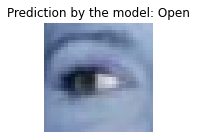

In [8]:
figure = plt.figure(figsize=(2, 2))
img_open2 = np.squeeze(img_open2, axis=0)
plt.imshow(img_open2)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_open2[0], axis=0)]}')
plt.show()

In [9]:
def full_face_detection_pipeline(input_image_path):
    face_cascade = cv2.CascadeClassifier('D:\\490jupy\\474lab\\490project\\haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier('D:\\490jupy\\474lab\\490project\\haarcascade_eye.xml')
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('D:\\490jupy\\474lab\\490project\\shape_predictor_68_face_landmarks.dat')
    fa = FaceAligner(predictor, desiredFaceWidth=256)
    test_image = cv2.imread(input_image_path)
    test_image = imutils.resize(test_image, width=800)
    test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
    rects = detector(test_image_gray, 2)
    for rect in rects:
        (x, y, w, h) = rect_to_bb(rect)
        faceOrig = imutils.resize(test_image[y:y+h, x:x+w], width=256)
        faceAligned = fa.align(test_image, test_image_gray, rect)
        faceAligned_gray = cv2.cvtColor(faceAligned, cv2.COLOR_BGR2GRAY)
        plt.imshow(faceAligned_gray)
        plt.axis('off')
        plt.title('Aligned Face')
        plt.show()
        eyes = eye_cascade.detectMultiScale(faceAligned_gray, 1.1, 4)
        predictions = []
        for (ex, ey, ew, eh) in eyes:
            eye = faceAligned[ey:ey+eh, ex:ex+ew]
#             cv2.rectangle(test_image, (x+ex, y+ey), (x+ex+ew, y+ey+eh), (0, 0, 255), 8)
            eye = cv2.resize(eye, (32, 32))
            eye = np.array(eye)
            eye = np.expand_dims(eye, axis=0)
            ypred = model.predict(eye)
            ypred = np.argmax(ypred[0], axis=0)
            predictions.append(ypred)
        if all(i==0 for i in predictions):
            cv2.rectangle(test_image, (x, y), (x+w, y+h), (0, 0, 255), 8)
            cv2.putText(test_image, 'Sleeping', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)
        else:
            cv2.rectangle(test_image, (x, y), (x+w, y+h), (0, 255, 0), 8)
            cv2.putText(test_image, 'Not Sleeping', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)
    output_path = 'test_image_prediction.jpg'
    cv2.imwrite(output_path, test_image) 
    return output_path

In [13]:
figure = plt.figure(figsize=(5, 5))
predicted_image = cv2.imread(full_face_detection_pipeline('D:\\490jupy\\CNN Drowsiness Detection Using a Convolutional Neural Network\\open1.jpg'))
predicted_image = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB)
plt.imshow(predicted_image)
plt.axis('off')
plt.show()

TypeError: Can't parse 'center'. Sequence item with index 0 has a wrong type

<Figure size 360x360 with 0 Axes>

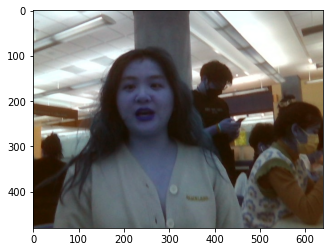

In [12]:
we = cv2.imread('D:\\490jupy\\CNN Drowsiness Detection Using a Convolutional Neural Network\\open1.jpg')
plt.imshow(we)

In [2]:
def eye_cropper(frame):

    # create a variable for the facial feature coordinates

    facial_features_list = face_recognition.face_landmarks(frame)


    # create a placeholder list for the eye coordinates
    # and append coordinates for eyes to list unless eyes
    # weren't found by facial recognition

    try:
        eye = facial_features_list[0]['left_eye']
    except:
        try:
            eye = facial_features_list[0]['right_eye']
        except:
            return


    # establish the max x and y coordinates of the eye

    x_max = max([coordinate[0] for coordinate in eye])
    x_min = min([coordinate[0] for coordinate in eye])
    y_max = max([coordinate[1] for coordinate in eye])
    y_min = min([coordinate[1] for coordinate in eye])


    # establish the range of x and y coordinates

    x_range = x_max - x_min
    y_range = y_max - y_min


      # in order to make sure the full eye is captured,
      # calculate the coordinates of a square that has a
      # 50% cushion added to the axis with a larger range and
      # then match the smaller range to the cushioned larger range

    if x_range > y_range:
        right = round(.5*x_range) + x_max
        left = x_min - round(.5*x_range)
        bottom = round((((right-left) - y_range))/2) + y_max
        top = y_min - round((((right-left) - y_range))/2)
    else:
        bottom = round(.5*y_range) + y_max
        top = y_min - round(.5*y_range)
        right = round((((bottom-top) - x_range))/2) + x_max
        left = x_min - round((((bottom-top) - x_range))/2)


    # crop the image according to the coordinates determined above

    cropped = frame[top:(bottom + 1), left:(right + 1)]

    # resize the image

    cropped = cv2.resize(cropped, (32,32))
    #image_for_prediction = cropped.reshape(-1, 32, 32, 3)
    image_for_prediction = cv2.resize(cropped, (32,32))


    return image_for_prediction

0

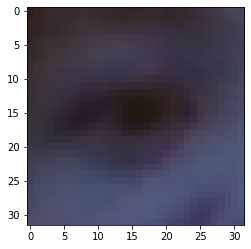

In [4]:
eye_model = keras.models.load_model('Driver_Drowsiness_Detection.h5')
img = cv2.imread('open1.jpg')
image_for_prediction = eye_cropper(img)
plt.imshow(image_for_prediction)
image_for_prediction = np.array(image_for_prediction)
image_for_prediction = np.expand_dims(image_for_prediction, axis=0)
#image_for_prediction = image_for_prediction/255.0
prediction = eye_model.predict(image_for_prediction)
prediction = np.argmax(prediction[0], axis=0)
prediction 

In [ ]:
cap = cv2.VideoCapture(0)
w = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
h = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
print(cap.get(cv2.CAP_PROP_FPS))


if not cap.isOpened():
    raise IOError('Cannot open webcam')

# set a counter

counter = 0

# create a while loop that runs while webcam is in use

while True:

    # capture frames being outputted by webcam

    ret, frame = cap.read()

    # use only every other frame to manage speed and memory usage

    frame_count = 0
    if frame_count == 0:
        frame_count += 1
        pass
    else:
        count = 0
        continue

    # function called on the frame

    image_for_prediction = eye_cropper(frame)
    try:
        image_for_prediction = np.array(image_for_prediction)
        image_for_prediction = np.expand_dims(image_for_prediction, axis=0)
    except:
        continue

    # get prediction from model

    prediction = eye_model.predict(image_for_prediction)
    prediction = np.argmax(prediction[0], axis=0)

    # Based on prediction, display either "Open Eyes" or "Closed Eyes"

    if prediction == 0:
        counter = 0
        status = 'Open'

        cv2.rectangle(frame, (round(w/2) - 110,20), (round(w/2) + 110, 32), (38,38,38), -1)

        cv2.putText(frame, status, (round(w/2)-32,70), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 2, cv2.LINE_4)
        x1, y1,w1,h1 = 0,0,175,75
        ## Draw black backgroun rectangle
        cv2.rectangle(frame, (x1,x1), (x1+w1-20, y1+h1-20), (0,0,0), -1)
        ## Add text
        cv2.putText(frame, 'Active', (x1 +int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255,0),2)
    else:
        counter = counter + 1
        status = 'Closed'

        cv2.rectangle(frame, (round(w/2) - 110,20), (round(w/2) + 110, 32), (38,38,38), -1)

        cv2.putText(frame, status, (round(w/2)-104,70), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 2, cv2.LINE_4)
        x1, y1,w1,h1 = 0,0,175,75
        ## Draw black backgroun rectangle
        cv2.rectangle(frame, (x1,x1), (x1+w1-20, y1+h1-20), (0,0,0), -1)
        ## Add text
        cv2.putText(frame, 'Active', (x1 +int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255,0),2)


        # if the counter is greater than 3, play and show alert that user is asleep

        if counter > 2:

            x1, y1, w1, h1 = 400,400,400,100
            
            cv2.rectangle(frame, (round(w/2) - 160, round(h) - 200), (round(w/2) + 160, round(h) - 120), (0,0,255), -1)

            cv2.putText(frame, 'SLEEPING', (round(w/2)-136,round(h) - 146), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2, cv2.LINE_4)

            cv2.imshow('Drowsiness Detection', frame)
            k = cv2.waitKey(1)
            ## Sound
            #playsound('rooster.mov')
            counter = 1
            continue
    cv2.imshow('Drowsiness Detection', frame)
    k = cv2.waitKey(1)
    if k == 27:
        break
cap.release()
cv2.destroyAllWindows()